In [19]:
from mesa import Agent, Model

import matplotlib.pyplot as plt
from IPython.display import clear_output

In [20]:
from mesa.space import MultiGrid
from mesa.time import RandomActivation, BaseScheduler
from mesa.datacollection import DataCollector

In [21]:
import numpy as np
import matplotlib.colors
import random
import math

In [101]:
# class for agents (passengers)

class Passenger(Agent):

    def __init__(self, unique_id, model, max_speed, seat_original):
        super().__init__(unique_id, model)
        self.max_speed = max_speed
        self.speed = max_speed
        self.remaining_steps = 0
        self.original_pos = seat_original
        
        # counter of the steps necessary to exit the aircraft
        self.tot_steps = 0
        
    # function that let the agents move - Boeing 737    
    def move_737(self):

        # If the agent still has remaining steps, do nothing
        if self.remaining_steps > 0:
            self.remaining_steps -= 1
            return

        # Define possible steps based on current position
        x, y = self.pos
        possible_steps = []
        
        # check if agent is in the top cell before the exit
        if (x, y) == (0, 3):
            possible_steps.append((x, y))
        
        # if not before the exit, calculate possible steps based on specified strategy
        else:
            # front to back strategy --> passengers can move once the seats of the row in front is empty
            if self.model.strategy == "front_back":
                occ_prev = self.model.count_agents_in_row(self.model.grid, x-1, False)
                if occ_prev == 0:
                    if y == 3:
                        possible_steps.append((x-1, y))
                    elif y > 3:
                        possible_steps.append((x, y-1))
                    else:
                        possible_steps.append((x, y+1))
                else:
                    possible_steps.append((x, y))

            # back to front strategy --> passengers can move once the seats of the row behind are empty
            elif self.model.strategy == "back_front":
                try: occ_prev = self.model.count_agents_in_row(self.model.grid, x+1)
                except: occ_prev = 0
                if y == 3:
                    possible_steps.append((x-1, y))

                else:
                    if occ_prev != 0:
                        possible_steps.append((x, y))
                    else:
                        
                        if y > 3:
                            possible_steps.append((x, y-1))
                        elif y<3:
                            possible_steps.append((x, y+1))
            
            # reverse pyramid strategy --> passengers are assigned to groups based on this strategy and each group can move when the seats of previous group are empty
            elif self.model.strategy == "reverse pyramid":
                group1 = [seat for seat in self.model.seats if (seat[0] <= 14 and (seat[1] == 2 or seat[1] == 4))]
                group2 = [seat for seat in self.model.seats if (seat[0] >= 15 and (seat[1] == 2 or seat[1] == 4)) or (seat[0] <= 8 and (seat[1] == 1 or seat[1] == 5))]
                group3 = [seat for seat in self.model.seats if ((seat[0] >= 9 and seat[0] <= 16) and (seat[1] == 1 or seat[1] == 5)) or (seat[0] <= 8 and (seat[1] == 0 or seat[1] == 6))]
                group4 = [seat for seat in self.model.seats if (seat[0] >= 17 and (seat[1] == 1 or seat[1] == 5)) or ((seat[0] >= 9 and seat[0] <= 14) and (seat[1] == 0 or seat[1] == 6))]
                group5 = [seat for seat in self.model.seats if seat[0] >= 15 and (seat[1] == 0 or seat[1] == 6)]
                
                if y == 3:
                    possible_steps.append((x-1, y))
                
                else:
                    if len(group1) > 0:
                        
                        if self.original_pos in group1:  
                            if y < 3:
                                possible_steps.append((x, y+1))
                            else:
                                possible_steps.append((x, y-1))
                        else:
                            possible_steps.append((x, y))
                            
                    elif len(group2) > 0:
                        
                        if self.original_pos in group2: 
                            if y < 3:
                                possible_steps.append((x, y+1))
                            else:
                                possible_steps.append((x, y-1))
                        else:
                            possible_steps.append((x, y))
                    
                    elif len(group3) > 0:
                        
                        if self.original_pos in group3: 
                            if y < 3:
                                possible_steps.append((x, y+1))
                            else:
                                possible_steps.append((x, y-1))
                        else:
                            possible_steps.append((x, y))
                            
                    elif len(group4) > 0:
                        
                        if self.original_pos in group4 : 
                            if y < 3:
                                possible_steps.append((x, y+1))
                            else:
                                possible_steps.append((x, y-1))
                        else:
                            possible_steps.append((x, y))
                    else:
                        
                        if y < 3:
                            possible_steps.append((x, y+1))
                        else:
                            possible_steps.append((x, y-1))

            
            # wilma strategy --> passengers are divided in three groups (aisle, middle, window). The first to move are the passengers in the aisle seats 
            elif self.model.strategy == "wilma":
                
                group1 = [seat for seat in self.model.seats if seat[1] == 2 or seat[1] == 4]
                group2 = [seat for seat in self.model.seats if seat[1] == 1 or seat[1] == 5]
                group3 = [seat for seat in self.model.seats if seat[1] == 0 or seat[1] == 6]
                
                if y == 3:
                    possible_steps.append((x-1, y))
                
                else:
                    if len(group1) > 0:
                        
                        if y == 2 or y == 4:
                            if y == 2:
                                possible_steps.append((x, y+1))
                            else:
                                possible_steps.append((x, y-1))
                        else:
                            possible_steps.append((x, y))
                                
                    elif len(group2) > 0:
                        
                        if y == 1 or y == 5 or y == 2 or y == 4:
                            if y < 3:
                                possible_steps.append((x, y+1))
                            else:
                                possible_steps.append((x, y-1))    
                        else:
                            possible_steps.append((x, y))
                        
                    elif len(group3) > 0:
                        if y == 0 or y == 6 or y == 1 or y == 5 or y == 2 or y == 4:
                            if y < 3:
                                possible_steps.append((x, y+1))
                            else:
                                possible_steps.append((x, y-1))    
                        else:
                            possible_steps.append((x, y))

            # blocks strategy --> passengers are divided in groups. They can move once the previous group's seats are empty
            elif self.model.strategy == "blocks":
                
                group1 = [seat for seat in self.model.seats if seat[0] < 5]
                group2 = [seat for seat in self.model.seats if seat[0] >= 5 and seat[0] < 10]
                group3 = [seat for seat in self.model.seats if seat[0] >= 10 and seat[0] < 15]
                group4 = [seat for seat in self.model.seats if seat[0] >= 15 and seat[0] < 20]
                group5 = [seat for seat in self.model.seats if seat[0] >= 20 and seat[0] < 26]
                group6 = [seat for seat in self.model.seats if seat[0] >= 26]
                
                
                if y == 3:
                    possible_steps.append((x-1, y))
                
                else:
                    if len(group1) > 0:
                        if x < 5:
                            if y < 3:
                                possible_steps.append((x, y+1))
                            else:
                                possible_steps.append((x, y-1))
                        else:
                            if self.model.count_agents_in_row(self.model.grid, x-1) == 0:
                                if y < 3:
                                    possible_steps.append((x, y+1))
                                else:
                                    possible_steps.append((x, y-1))  
                            else:        
                                possible_steps.append((x, y))

                    elif len(group2) > 0:   
                        if x >= 5 and x < 10:
                            if y < 3:
                                possible_steps.append((x, y+1))
                            else:
                                possible_steps.append((x, y-1))    
                        else:
                            if self.model.count_agents_in_row(self.model.grid, x-1) == 0:
                                if y < 3:
                                    possible_steps.append((x, y+1))
                                else:
                                    possible_steps.append((x, y-1))  
                            else:        
                                possible_steps.append((x, y))
                        
                    elif len(group3) > 0:
                        if x >= 10 and x < 15:
                            if y < 3:
                                possible_steps.append((x, y+1))
                            else:
                                possible_steps.append((x, y-1))    
                        else:
                            if self.model.count_agents_in_row(self.model.grid, x-1) == 0:
                                if y < 3:
                                    possible_steps.append((x, y+1))
                                else:
                                    possible_steps.append((x, y-1))  
                            else:        
                                possible_steps.append((x, y))
                            
                    elif len(group4) > 0:
                        if x >= 15 and x < 20:
                            if y < 3:
                                possible_steps.append((x, y+1))
                            else:
                                possible_steps.append((x, y-1))    
                        else:
                            if self.model.count_agents_in_row(self.model.grid, x-1) == 0:
                                if y < 3:
                                    possible_steps.append((x, y+1))
                                else:
                                    possible_steps.append((x, y-1))  
                            else:        
                                possible_steps.append((x, y))
                    
                    elif len(group5) > 0:
                        if x >= 20 and x < 26:
                            if y < 3:
                                possible_steps.append((x, y+1))
                            else:
                                possible_steps.append((x, y-1))    
                        else:
                            if self.model.count_agents_in_row(self.model.grid, x-1) == 0:
                                if y < 3:
                                    possible_steps.append((x, y+1))
                                else:
                                    possible_steps.append((x, y-1))  
                            else:        
                                possible_steps.append((x, y))
                    
                    else:
                        if y < 3:
                            possible_steps.append((x, y+1))
                        else:
                            possible_steps.append((x, y-1))    
              
            
            # steffen strategy --> first the passengers in odd_rows can move, then the passengers in even_rows            
            elif self.model.strategy == "steffen":
                even_rows = [seat for seat in self.model.seats if seat[0]%2 == 0]   
                odd_rows = [seat for seat in self.model.seats if seat[0]%2 != 0]
                
                if y == 3:
                    possible_steps.append((x-1, y))
                else:
                    if len(odd_rows) > 0:
                        if x%2 != 0:
                            if y < 3:
                                possible_steps.append((x, y+1))
                            else:
                                possible_steps.append((x, y-1))
                    else:
                        if y < 3:
                            possible_steps.append((x, y+1))
                        else:
                            possible_steps.append((x, y-1))
            
            # adjusted steffen strategy --> passengers are divided in groups based on the row of their seats. 
            elif self.model.strategy == "adjusted steffen":
                group1 = [seat for seat in self.model.seats if seat[0] == 0 or seat[0]%3 == 0]   
                group2 = [seat for seat in self.model.seats if seat[0] == 1 or seat[0]%3 == 1]
                group3 = [seat for seat in self.model.seats if seat[0] == 2 or seat[0]%3 == 2]
                
                if y == 3:
                    possible_steps.append((x-1, y))
                else:
                    if len(group1) > 0:
                        if x == 0 or x%3 == 0:
                            if y < 3:
                                possible_steps.append((x, y+1))
                            else:
                                possible_steps.append((x, y-1))
                        else:
                            possible_steps.append((x, y))
                            
                    elif len(group2) > 0:
                        if x == 1 or x%3 == 1:
                            if y < 3:
                                possible_steps.append((x, y+1))
                            else:
                                possible_steps.append((x, y-1))
                        else:
                            possible_steps.append((x, y))
                    
                    elif len(group3) > 0:
                        if y < 3:
                            possible_steps.append((x, y+1))
                        else:
                            possible_steps.append((x, y-1))
                        
                    
            # random strategy
            else:
                if y == 3:    
                    possible_steps.append((x-1, y))
                elif y > 3:
                    possible_steps.append((x, y-1))
                else:
                    possible_steps.append((x, y+1))

            
        # Update walking speed based on number of agents in the in the aisle and in the aircraft --> exponential increase in speed
        num_agents = len(self.model.schedule.agents)
        tot_agents = self.model.num_agents
        aisle_agents = self.model.count_agents_in_column_before_row(self.model.grid, x)
        max_aisle_agents = 64
        
        # at the beggining passengers' speed is lower because the aircraft is over-crowded
        if  y == 3:
            self.speed = self.max_speed * math.exp(-aisle_agents / max_aisle_agents)
        else:    
            self.speed = self.max_speed * math.exp(-num_agents / 100)
        
        if self.speed > self.max_speed:
            self.speed = self.max_speed
        
        
        
        # Calculate necessary steps based on agent speed - this is needed to respect passenger's speed
        if self.speed < self.max_speed:
            distance_to_travel = 0.92 # assumed cell size
            steps = math.ceil(distance_to_travel / self.speed) 
            self.remaining_steps = steps - 1
            

        # check if the adjacent cells are full
        for cell in possible_steps:
            # take the list of agents in the cell in which an agent can move to
            occupants = self.model.grid.get_cell_list_contents([cell])
            
            # if the cell is empty, the agent can move there
            if len(occupants) == 0:
                new_position = cell
                break
            
            # if the cell is occupied by one agent, the agent can move there only if that cell is in an aisle cell
            elif len(occupants) == 1:
                if cell[1] == 3: # check if passenger is in the aisle
                    new_position = cell
                    break
                else:
                    new_position = self.pos
            # if the cell has 2 agents, the agent can't move there
            elif len(occupants) == 2:
                new_position = self.pos
                break
        
        # if there are no possible steps, the agent stays in the same cell
        if len(possible_steps)==0:
            new_position = self.pos
        
        # move the agent to the new position
        self.model.grid.move_agent(self, new_position)  # <-- move there

    
    # function that let the agents move - Boeing 777
    def move_777(self):
        
        # If the agent still has remaining steps, do nothing
        if self.remaining_steps > 0:
            self.remaining_steps -= 1
            return
        
        # Define possible steps based on current position
        x, y = self.pos
        possible_steps = []
        
        
        # create groups based on seats class
        first_class = [seat for seat in self.model.seats if seat[0] < 2]
        business_class = [seat for seat in self.model.seats if seat[0] >= 2 and seat[0] < 8]
        economy_class = [seat for seat in self.model.seats if seat[0] >= 8]
        
        # calculate possible steps based on strategy
        # first the passengers in first and business class can exit, then the passengers in economy class
        
        # check if agent is in the top cell before the exit
        if (x, y) == (0, 3) or (x, y) == (0, 8):
            possible_steps.append((x, y))
        # if not before the exit, calculate possible steps based on specified strategy
        else: 
            # first, passengers in first class can move
            if len(first_class) > 0:
                if x < 2:
                    if y < 3 or (y >= 5 and y < 8):    
                        possible_steps.append((x, y+1))
                    elif y > 8 or (y < 5 and y > 3):
                        possible_steps.append((x, y-1))
                    elif y == 3 or y == 8:
                        possible_steps.append((x-1, y))
                    
                else:
                    possible_steps.append((x, y))
                
            # when first class is empty, passengers in business class can move
            elif len(business_class) > 0:
                if x < 8:
                    if y < 3 or (y > 5 and y < 8):    
                        possible_steps.append((x, y+1))
                    elif y > 8 or (y <= 5 and y > 3):
                        possible_steps.append((x, y-1))
                    elif y == 3 or y == 8:
                        possible_steps.append((x-1, y))    
                        
                    
                else:
                    possible_steps.append((x, y))
            
            #when business class is empty, passengers in economy class can move
            # only the passengers in economy class must follow a strategy
            else:   
                # random strategy
                if self.model.strategy == "random":
                    if y < 3 or (y > 5 and y < 8):    
                        possible_steps.append((x, y+1))
                    elif y > 8 or (y <= 5 and y > 3):
                        possible_steps.append((x, y-1))
                    elif y == 3 or y == 8:
                        possible_steps.append((x-1, y))
                
                # front to back strategy --> passengers can move once the seats of the row in front is empty         
                elif self.model.strategy == "front_back":
                    occ_prev = self.model.count_agents_in_row(self.model.grid, x-1, False)
                    if occ_prev == 0:
                        if y == 3 or y == 8:
                            possible_steps.append((x-1, y))
                        elif  y > 8 or (y <= 5 and y > 3):
                            possible_steps.append((x, y-1))
                        else:
                            possible_steps.append((x, y+1))
                    else:
                        possible_steps.append((x, y))
                
                # back to front strategy --> passengers can move once the seats of the row behind are empty                
                elif self.model.strategy == "back_front":
                    try: occ_prev = self.model.count_agents_in_row(self.model.grid, x+1)
                    except: occ_prev = 0
                    if y == 3 or y == 8:
                        possible_steps.append((x-1, y))
                    else:
                        if occ_prev != 0:
                            possible_steps.append((x, y))
                        else:
                            if  y > 8 or (y <= 5 and y > 3):
                                possible_steps.append((x, y-1))
                            else:
                                possible_steps.append((x, y+1))
                
                # wilma strategy, adjusted for Boeing 777 seats setting
                elif self.model.strategy == "adjusted wilma":
                    
                    group1 = [seat for seat in self.model.seats if (seat[1] == 2 or seat[1] == 9) or (seat[1] == 4 or seat[1] == 7)]
                    group2 = [seat for seat in self.model.seats if (seat[1] == 1 or seat[1] == 10) or (seat[1] == 5 or seat[1] == 6)]
                    group3 = [seat for seat in self.model.seats if seat[1] == 0 or seat[1] == 11]
                    if y == 3 or y == 8:
                        possible_steps.append((x-1, y))
                    else:

                        if len(group1) > 0:
                            if y == 2 or y == 9 or y == 4 or y == 7:
                                if y < 3 or (y > 5 and y < 8):
                                    possible_steps.append((x, y+1))
                                else:
                                    possible_steps.append((x, y-1))
                            else:
                                possible_steps.append((x, y))
                        
                        elif len(group2) > 0:
                            if y >= 1 and y <= 10:
                                if y < 3 or (y > 5 and y < 8):
                                    possible_steps.append((x, y+1))
                                else:
                                    possible_steps.append((x, y-1))   
                            else:
                                possible_steps.append((x, y))
                        
                        elif len(group3) > 0:
                            if y >= 0 or y <= 11:
                                if y < 3 or (y > 5 and y < 8):
                                    possible_steps.append((x, y+1))
                                else:
                                    possible_steps.append((x, y-1))
                                
                            else:
                                possible_steps.append((x, y))
                
                # steffen strategy
                elif self.model.strategy == "steffen":
                    even_rows = [seat for seat in self.model.seats if seat[0]%2 == 0]   
                    odd_rows = [seat for seat in self.model.seats if seat[0]%2 != 0]
                    
                    if y == 3 or y == 8:
                        possible_steps.append((x-1, y))
                    else:
                        if len(even_rows) > 0:
                            if x%2 == 0:
                                if y < 3 or (y > 5 and y < 8):
                                    possible_steps.append((x, y+1))
                                else:
                                    possible_steps.append((x, y-1))
                        else:
                            if y < 3 or (y > 5 and y < 8):
                                possible_steps.append((x, y+1))
                            else:
                                possible_steps.append((x, y-1))
                
                # adjusted steffen strategy
                elif self.model.strategy == "adjusted steffen":
                    group2 = [seat for seat in self.model.seats if seat[0] == 9 or seat[0]%3 == 0]   
                    group3 = [seat for seat in self.model.seats if seat[0] == 10 or seat[0]%3 == 1]
                    group1 = [seat for seat in self.model.seats if seat[0] == 8 or seat[0]%3 == 2]
                    
                    if y == 3 or y == 8:
                        possible_steps.append((x-1, y))
                    else:
                        if len(group1) > 0:
                            if x%3 == 2:
                                if y < 3 or (y > 5 and y < 8):
                                    possible_steps.append((x, y+1))
                                else:
                                    possible_steps.append((x, y-1))
                            else:
                                possible_steps.append((x, y))
                                
                        elif len(group2) > 0:
                            if x == 1 or x%3 == 0:
                                if y < 3 or (y > 5 and y < 8):
                                    possible_steps.append((x, y+1))
                                else:
                                    possible_steps.append((x, y-1))
                            else:
                                possible_steps.append((x, y))
                        
                        elif len(group3) > 0:
                            if y < 3 or (y > 5 and y < 8):
                                possible_steps.append((x, y+1))
                            else:
                                possible_steps.append((x, y-1))
                
                # blocks strategy                
                elif self.model.strategy == "blocks":
            
                    group1 = [seat for seat in self.model.seats if seat[0] < 5]
                    group2 = [seat for seat in self.model.seats if seat[0] >= 5 and seat[0] < 10]
                    group3 = [seat for seat in self.model.seats if seat[0] >= 10 and seat[0] < 15]
                    group4 = [seat for seat in self.model.seats if seat[0] >= 15 and seat[0] < 20]
                    group5 = [seat for seat in self.model.seats if seat[0] >= 20 and seat[0] < 26]
                    group6 = [seat for seat in self.model.seats if seat[0] >= 26]
                    
                    
                    if y == 3 or y == 8:
                        possible_steps.append((x-1, y))
                    
                    else:
                        if len(group1) > 0:
                            if x < 5:
                                if y < 3 or (y > 5 and y < 8):
                                    possible_steps.append((x, y+1))
                                else:
                                    possible_steps.append((x, y-1))
                            else:
                                if self.model.count_agents_in_row(self.model.grid, x-1) == 0:
                                    if y < 3 or (y > 5 and y < 8):
                                        possible_steps.append((x, y+1))
                                    else:
                                        possible_steps.append((x, y-1))  
                                else:        
                                    possible_steps.append((x, y))

                        elif len(group2) > 0:   
                            if x >= 5 and x < 10:
                                if y < 3 or (y > 5 and y < 8):
                                    possible_steps.append((x, y+1))
                                else:
                                    possible_steps.append((x, y-1))    
                            else:
                                if self.model.count_agents_in_row(self.model.grid, x-1) == 0:
                                    if y < 3 or (y > 5 and y < 8):
                                        possible_steps.append((x, y+1))
                                    else:
                                        possible_steps.append((x, y-1))  
                                else:        
                                    possible_steps.append((x, y))
                            
                        elif len(group3) > 0:
                            if x >= 10 and x < 15:
                                if y < 3 or (y > 5 and y < 8):
                                    possible_steps.append((x, y+1))
                                else:
                                    possible_steps.append((x, y-1))    
                            else:
                                if self.model.count_agents_in_row(self.model.grid, x-1) == 0:
                                    if y < 3 or (y > 5 and y < 8):
                                        possible_steps.append((x, y+1))
                                    else:
                                        possible_steps.append((x, y-1))  
                                else:        
                                    possible_steps.append((x, y))
                                
                        elif len(group4) > 0:
                            if x >= 15 and x < 20:
                                if y < 3 or (y > 5 and y < 8):
                                    possible_steps.append((x, y+1))
                                else:
                                    possible_steps.append((x, y-1))    
                            else:
                                if self.model.count_agents_in_row(self.model.grid, x-1) == 0:
                                    if y < 3 or (y > 5 and y < 8):
                                        possible_steps.append((x, y+1))
                                    else:
                                        possible_steps.append((x, y-1))  
                                else:        
                                    possible_steps.append((x, y))
                        
                        elif len(group5) > 0:
                            if x >= 20 and x < 26:
                                if y < 3 or (y > 5 and y < 8):
                                    possible_steps.append((x, y+1))
                                else:
                                    possible_steps.append((x, y-1))    
                            else:
                                if self.model.count_agents_in_row(self.model.grid, x-1) == 0:
                                    if y < 3 or (y > 5 and y < 8):
                                        possible_steps.append((x, y+1))
                                    else:
                                        possible_steps.append((x, y-1))  
                                else:        
                                    possible_steps.append((x, y))
                        
                        else:
                            if y < 3 or (y > 5 and y < 8):
                                possible_steps.append((x, y+1))
                            else:
                                possible_steps.append((x, y-1))    
                    
                            
        
                
        # Update walking speed based on number of agents in the in the aisle and in the model --> exponential increase in speed
        num_agents = len(self.model.schedule.agents)
        tot_agents = self.model.num_agents
        aisle_agents = self.model.count_agents_in_column_before_row(self.model.grid, x)
        
        if  y == 3 or y == 8:
            self.speed = self.max_speed * math.exp(-aisle_agents / 10)
        else:
            if self.original_pos in first_class:
                self.speed = self.max_speed * math.exp(-8 / 200)
            elif self.original_pos in business_class:
                self.speed = self.max_speed * math.exp(-48 / 200)
            else:    
                self.speed = self.max_speed * math.exp(-num_agents / 200)
        
        if self.speed > self.max_speed:
            self.speed = self.max_speed
                
        # Calculate necessary steps based on agent speed
        if self.speed < self.max_speed:
            distance_to_travel = 0.92 # assumed cell size
            steps = math.ceil(distance_to_travel / self.speed) 
            self.remaining_steps = steps - 1
            

        # check if the adjacent cells are full
        for cell in possible_steps:
            occupants = self.model.grid.get_cell_list_contents([cell])
            if len(occupants) == 0:
                new_position = cell
                break
                
            elif len(occupants) == 1:
                if cell[1] == 3 or cell[1] == 8: # check if passenger is in the aisle
                    new_position = cell
                    break
                else:
                    new_position = self.pos
            
            elif len(occupants) == 2:
                new_position = self.pos
                break
        
        
        if len(possible_steps)==0:
            new_position = self.pos
        
        
        self.model.grid.move_agent(self, new_position)  # <-- move there
        
        
    def step(self):
        
        if self.model.model == 737:
            self.move_737()
        else:
            self.move_777()
        

In [102]:
class AircraftModel(Model):
    """A model with some number of agents."""
    def __init__(self, aircraft_model, age_dec = 0.2, parent_dec = 0.15, luggage_fract = 0.85, child_fract = 0.1, old_fract = 0.1, parent_fract = 0.1, strategy = 'random'):
        self.model = aircraft_model
        
        # set aircraft models settings
        if self.model == 737:
            self.num_agents = 189
            num_rows = 32
            num_seats_per_row = 7
        else:
            self.num_agents = 356
            num_rows = 38
            num_seats_per_row = 12
        
        
        self.grid = MultiGrid(num_rows, num_seats_per_row, True) # <--- we define the type of space for our model  
        
        # specified disebarking strategy
        self.strategy = strategy
        
        # agents activation
        self.schedule = RandomActivation(self)
        
        
        if self.model == 737:
            # specify the position of the seats for Boeing 737
            removed_seats = [(0,4), (0,5), (0,6)]
            self.seats = [(row, col) for row in range(num_rows) for col in range(num_seats_per_row) if col != 3 and (row,col) not in removed_seats] # seats do not include the aisle
            
        else:
            # specify the position of the seats for Boeing 777
            removed_seats = [(0, 1),(0, 2),(0, 9),(0, 10),(0, 4),(0, 7),(1, 4),(1, 7),(1, 1),(1, 2),(1, 9),(1, 10),(2, 2),(2, 9),(3, 2),(3, 9),(4, 2),(4, 9),(5, 2),(5, 9),(6, 2),(6, 9),(7, 2),(7, 9)]
            self.seats = [(row, col) for row in range(num_rows) for col in range(num_seats_per_row) if (row, col) not in removed_seats and col != 3 and col != 8] # seats do not include the aisle


        
        self.running = True
        self.lugg_fract = luggage_fract  # <--- probability of a passenger having a luggage
        self.old_fract = old_fract       # <--- probability of a passenger being old
        self.child_fract = child_fract   # <--- probability of a passenger being a child
        self.parent_fract = parent_fract # <--- probability of a passenger being a parent

        # decrease of maximum walking speed for children, elders and parents
        self.age_dec = age_dec
        self.parent_dec = parent_dec
        
        
        
        # change seats order based on the specified srategy
        if self.strategy == 'random':
            seats_order = self.seats.copy()
        elif self.strategy == 'wilma':
            seats_order = self.wilma(self.seats)
        elif self.strategy == 'reverse pyramid':
            seats_order = self.seats
        elif self.strategy == 'steffen':
            seats_order = self.steffen(self.seats)
        elif self.strategy == 'front_back':
            seats_order = self.seats.copy()
        elif self.strategy == 'back_front':
            seats_order = self.seats[::-1]
        elif self.strategy == 'blocks':
            seats_order = self.blocks(self.seats)
        elif self.strategy == 'adjusted steffen':
            seats_order = self.adj_steffen(self.seats)
        else:
            seats_order = self.seats.copy()
            
        
        # Create and add agents to the model
        for i in range(self.num_agents):
            
            # assign agent to a seat 
            seat = self.random.choice(seats_order)
            

            max_speed = 0.92 # <--- max speed of the agent in m/s
            # randomly assign a luggage to the passenger
            # passengers with luggage have lower max speed - decrease based on literature
            if random.random() < self.lugg_fract:
                # diminish max speed using normal distribution in order to have a wait of 25 seconds
                waiting = np.random.normal(loc=10, scale=8)  # mean=0.3, std=0.02
                distance_from_exit = seat[0]*0.92
                std_tot_time = distance_from_exit / max_speed
                new_tot_time = std_tot_time + waiting
                max_speed = max(0.2, std_tot_time / new_tot_time)

            # randomly assign passenger to old or child or parent category and assign corresponding max speed decrease - decrease based on model calibration
            if random.random() < self.child_fract:
                max_speed -= np.random.normal(loc=self.age_dec, scale=0.03)  
            elif random.random() < self.old_fract:
                max_speed -=  np.random.normal(loc=self.age_dec, scale=0.03) 
            elif random.random() < self.parent_fract:
                max_speed -=  np.random.normal(loc=self.parent_dec, scale=0.01)  
            
            # avoid to have too low max speed or negative max speed
            if max_speed < 0.1:
                max_speed = 0.1
                    
            # assigning to the agent max speed and seat coordinates
            a = Passenger(i, self, max_speed=max_speed, seat_original=seat)
            
            # adding agent to the model
            self.schedule.add(a)
            seats_order.remove(seat)
            self.grid.place_agent(a, seat)

        # setting data collector - it collects the removed agents at each step
        self.datacollector = DataCollector(
            model_reporters={"Agents Removed": lambda m: m.agents_removed},
            agent_reporters={},
        )

        self.running = True
        
        # counter of removed agents
        self.agents_removed = 0
     
    # step function        
    def step(self):
        # remove agents that exit the aircraft
        self.remove_agents_at_top()
        # collect data
        self.datacollector.collect(self)
        # step
        self.schedule.step()

    # remove agents that exit the aircraft  
    def remove_agents_at_top(self):
        if self.model == 737:
            top_cell = [(0, 3)] # <--- define the exit cell at the top of the aisle
        else:
            top_cell = [(0, 3), (0, 8)]
        
        for c in top_cell:
            if len(self.grid.get_cell_list_contents([c])) > 0 : # se c'è almeno un passeggero nell'ultima cella, viene fatto uscire
                
                agent = self.grid.get_cell_list_contents([c])[0]
                # remove the agent from the list of seats
                self.agents_removed += 1
                
                # remove passenger from the model
                self.grid.remove_agent(agent) # <--- here we remove just one agent at a time
                self.schedule.remove(agent)
                
                # here we remove agents from the first and business class groups
                if self.model == 777:
                    if agent.original_pos[0] < 8:
                        self.seats.remove(agent.original_pos)
                    
                    # for economy class
                    else:
                        if self.strategy == 'wilma' or self.strategy == 'adjusted wilma':
                            self.seats.remove(agent.original_pos)
                        if self.strategy == 'blocks':
                            self.seats.remove(agent.original_pos)
                        if self.strategy == 'steffen' or self.strategy == 'adjusted steffen':
                            self.seats.remove(agent.original_pos)
                
                # for the 737 model        
                else:
                    if self.strategy == 'wilma' or self.strategy == 'adjusted wilma':
                        self.seats.remove(agent.original_pos)
                    if self.strategy == 'blocks':
                        self.seats.remove(agent.original_pos)
                    if self.strategy == 'steffen' or self.strategy == 'adjusted steffen':
                        self.seats.remove(agent.original_pos)

                
        
    # support functions            
    def wilma(self, seat_list):
        new_order = []
        list1 = []
        list2 = []
        list3 = []
        for seat in seat_list:
            if seat[1] == 2 or seat[1] == 4:
                list1.append(seat)
            elif seat[1] == 1 or seat[1] == 5:
                list2.append(seat)
            else:
                list3.append(seat)
                
        new_order = list1 + list2 + list3
        return new_order
    
    def steffen(self, seat_list):
        # sort the seats based on their column and then row
        sorted_seats = sorted(seat_list, key=lambda x: (x[1], x[0]))
        
        # create two empty lists for odd and even rows
        odd_rows = []
        even_rows = []
        
        # loop through the sorted seats and add them to the corresponding row list
        for seat in sorted_seats:
            if seat[0] % 2 == 0:
                even_rows.append(seat)
            else:
                odd_rows.append(seat)
        
        # combine the odd and even rows to form the final sorted list of seats
        sorted_seats = even_rows + odd_rows
        
        return sorted_seats
    
    def adj_steffen(self, seat_list): 
        b1 = []
        b2 = []
        b3 = []

        for s in seat_list:
            if s[0] == 0 or s[0]%3 == 0:
                b1.append(s)
            elif s[0] == 1 or s[0]%3 == 1:
                b2.append(s)
            else:
                b3.append(s)

        return b1+b2+b3
    
    def blocks(self, seat_list):
        b1 = []
        b2 = []
        b3 = []
        b4 = []
        b5 = []
        b6 = []

        for s in seat_list:
            if s[0] < 5:
                b1.append(s)
            elif s[0] < 10:
                b2.append(s)
            elif s[0] < 15:
                b3.append(s)
            elif s[0] < 20:
                b4.append(s)
            elif s[0] < 26:
                b5.append(s)
            else:
                b6.append(s)

        ordered_list = b1+b2+b3+b4+b5+b6
        return ordered_list
    
    
    def count_agents_in_row(self, grid, row, Aisle=True):
        agent_count = 0
        if row < 0:
            return 0
        
        for idx, cell in enumerate(grid.grid[row]):
            if Aisle or (idx != 3 and idx != 8):
                if cell:
                    agent_count += len(cell) if isinstance(cell, list) else 1
        return agent_count

    def count_agents_in_column_before_row(self, grid, row, column=3):
        agent_count = 0
        for r in range(row):
            cell = grid.grid[r][column]
            if cell:
                agent_count += len(cell) if isinstance(cell, list) else 1
            
        return agent_count

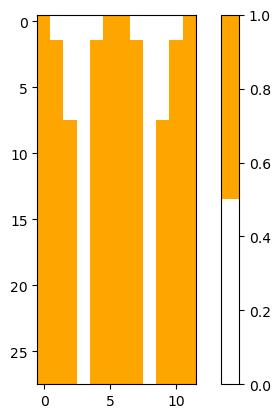

In [163]:
# seat map for Boeing 777
model = AircraftModel(777 ,256, 28, 12)

agent_counts = np.zeros((model.grid.width, model.grid.height)) 

for cell in model.grid.coord_iter():
    cell_content, x, y = cell
    agent_count = len(cell_content)
    agent_counts[x][y] = agent_count
cmap = matplotlib.colors.ListedColormap(['white', 'orange'])
plt.imshow(agent_counts, interpolation='nearest', cmap=cmap)
plt.colorbar()
plt.show()

Example of simulation for Boeing777

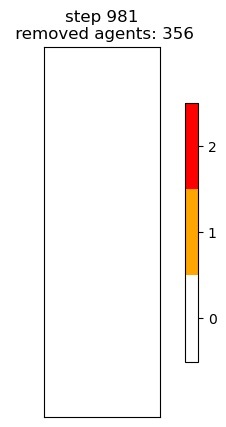

All passengers have exited the aircraft


In [110]:
# set parameters
luggage_fract = 0.85
child_fract = 0.1
old_fract = 0.1
parent_fract = 0.1

# create the model
model = AircraftModel(777, age_dec = 0.2, parent_dec = 0.15, luggage_fract=luggage_fract, child_fract=child_fract, old_fract=old_fract, parent_fract=parent_fract, strategy='back_front')
passengers_count = np.zeros((model.grid.width, model.grid.height)) 
removed_agents = []

# plot the initial state of the model
cmap = matplotlib.colors.ListedColormap(['white', 'orange', 'red'])
norm = matplotlib.colors.Normalize(vmin=-0.5, vmax=2.5)
for cell in model.grid.coord_iter():
    cell_content, x, y = cell
    passenger_count = len(cell_content)
    passengers_count[x][y] = passenger_count

plt.imshow(passengers_count, interpolation='nearest', cmap=cmap, norm=norm)
plt.title(f'step 0\n removed agents: 0')
plt.colorbar(ticks=[0, 1, 2], shrink=0.7)
plt.tick_params(axis='both', which='both', bottom=False, left=False)
plt.xticks([])
plt.yticks([])
plt.show()

# plot the state of the model at each step
i = 1
while len(model.schedule.agents) > 0:
    model.step()
    i += 1
    
    removed_agents_count = model.agents_removed
    removed_agents.append(removed_agents_count)
    
    passengers_count = np.zeros((model.grid.width, model.grid.height)) 

    for cell in model.grid.coord_iter():
        cell_content, x, y = cell
        passenger_count = len(cell_content)
        passengers_count[x][y] = passenger_count


    clear_output(wait=True)
    
    plt.imshow(passengers_count, interpolation='nearest', cmap=cmap, norm=norm)
    plt.title(f'step {i}\n removed agents: {removed_agents_count}')
    plt.colorbar(ticks=[0, 1, 2], shrink=0.7)
    plt.tick_params(axis='both', which='both', bottom=False, left=False)
    plt.xticks([])
    plt.yticks([])
    
    plt.show()

print("All passengers have exited the aircraft")

Example of simulation for Boeing737

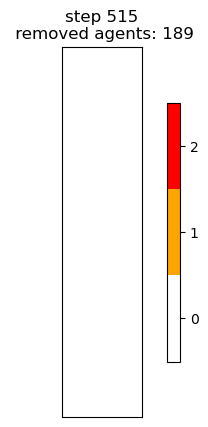

All passengers have exited the aircraft


In [164]:
# set parameters
luggage_fract = 0.85
child_fract = 0.1
old_fract = 0.1
parent_fract = 0.1

# create the model
model = AircraftModel(737, age_dec = 0.2, parent_dec = 0.2, luggage_fract=luggage_fract, child_fract=child_fract, old_fract=old_fract, parent_fract=parent_fract, strategy='wilma')
passengers_count = np.zeros((model.grid.width, model.grid.height)) 
removed_agents = []

# plot the initial state of the model
cmap = matplotlib.colors.ListedColormap(['white', 'orange', 'red'])
norm = matplotlib.colors.Normalize(vmin=-0.5, vmax=2.5)
for cell in model.grid.coord_iter():
    cell_content, x, y = cell
    passenger_count = len(cell_content)
    passengers_count[x][y] = passenger_count

plt.imshow(passengers_count, interpolation='nearest', cmap=cmap, norm=norm)
plt.title(f'step 0\n removed agents: 0')
plt.colorbar(ticks=[0, 1, 2], shrink=0.7)
plt.tick_params(axis='both', which='both', bottom=False, left=False)
plt.xticks([])
plt.yticks([])
plt.show()

# plot the state of the model at each step
i = 1
while len(model.schedule.agents) > 0:
    model.step()
    i += 1
    
    removed_agents_count = model.agents_removed
    removed_agents.append(removed_agents_count)
    
    passengers_count = np.zeros((model.grid.width, model.grid.height)) 

    for cell in model.grid.coord_iter():
        cell_content, x, y = cell
        passenger_count = len(cell_content)
        passengers_count[x][y] = passenger_count


    clear_output(wait=True)
    
    plt.imshow(passengers_count, interpolation='nearest', cmap=cmap, norm=norm)
    plt.title(f'step {i}\n removed agents: {removed_agents_count}')
    plt.colorbar(ticks=[0, 1, 2], shrink=0.7)
    plt.tick_params(axis='both', which='both', bottom=False, left=False)
    plt.xticks([])
    plt.yticks([])
    
    plt.show()



print("All passengers have exited the aircraft")